In [1]:
import numpy as np
import importlib
import matplotlib.pyplot as plt

import representation
import kex_data
import kex_headers
import listmode
import petlink
import position

In [124]:
d=50*kex_headers.MM_PER_PIXEL[-1]
alpha = np.pi/5
scan_info = kex_headers.SCAN_DICT
theta = np.arange(scan_info['tx size'])*scan_info['tx rad']
ro = d*np.cos(alpha-theta)
R = np.array([np.cos(theta), np.sin(theta)])
midlor = np.array([ro*R[0], ro*R[1]])

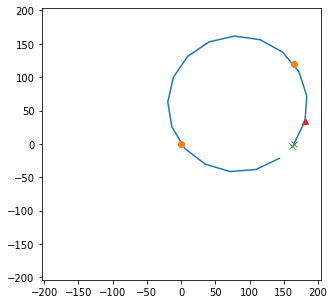

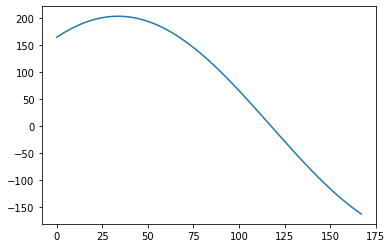

In [125]:
plt.figure(figsize=(5,5))
step=10 #uniformly distributed on circle? 
plt.plot(midlor[0][::step],midlor[1][::step])
plt.plot([0,d*np.cos(alpha)], [0, d*np.sin(alpha)],'o')
endkeys = (0,-1)
plt.plot(midlor[0,endkeys], midlor[1, endkeys],'x')
dirpoint = 10
plt.plot(midlor[0,dirpoint], midlor[1, dirpoint], '^')
plt.xlim(-d,d)
plt.ylim(-d,d)
plt.show()
plt.plot(ro)

In [126]:
N = len(theta)
toflor = {'tof': np.zeros(N), 
          'rm': np.zeros(N), 
          'rd':np.zeros(N),
          'ro': ro,
          'tx':theta}
toflor_bins, is_fov = representation.get_toflor_bins(toflor, scan_info)
print(np.sum(is_fov))
print(len(theta))

168
168


In [127]:
ibins = representation.circle_recon(toflor_bins, scan_info)

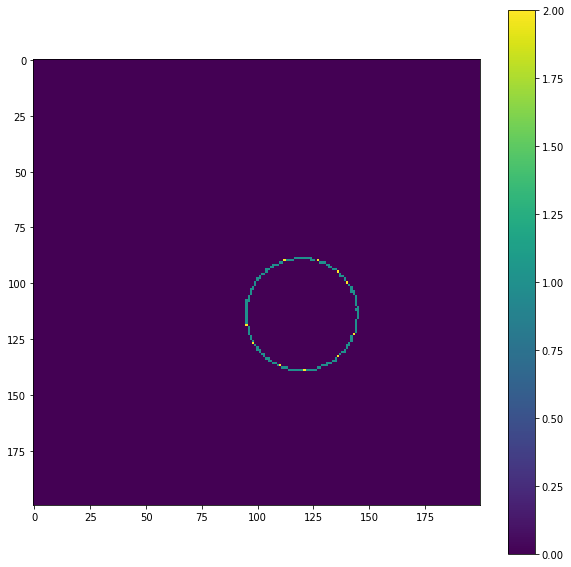

In [128]:
histo= listmode.get_histogram(ibins, kex_headers.IMAGE_SHAPE)
plt.figure(figsize=(10,10))
plt.imshow(histo[0])
plt.colorbar()
plt.show()

In [134]:
sinograms, _ = kex_data.sinograms()
scanid = ['cylinder 0', 'cylinder 1', 'kanyl 0', 'kanyl 1']
sinograms = dict(zip(scanid, np.array(sinograms, dtype=int)))

In [130]:
print(sinograms[scanid[0]].dtype)

int32


In [131]:
norms, _ = kex_data.get_norm_factors()
norms = dict(zip(scanid, norms))

In [132]:
#remove tof,normalize and random correct
prompts = {sid: np.sum(sinograms[sid][:-1], axis=0) for sid in scanid}
randoms = {sid: sinograms[sid][-1] for sid in scanid}
trues = {sid: np.maximum(prompts[sid]-randoms[sid],0) for sid in scanid}
norm_trues = {sid: trues[sid]*norms[sid] for sid in scanid}

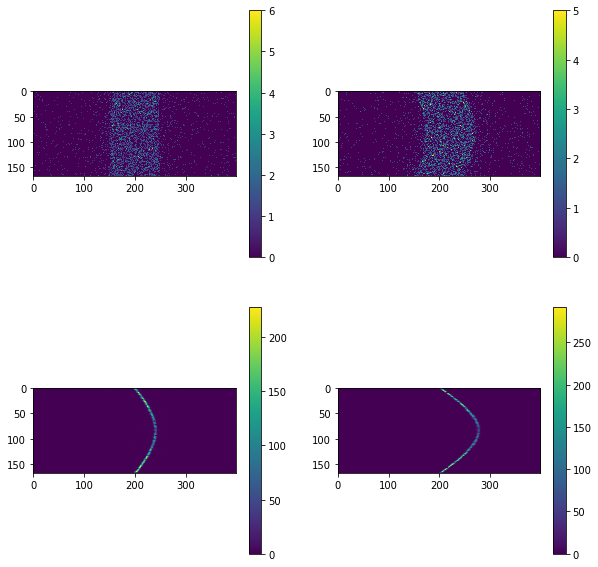

In [133]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = dict(zip(scanid, axes.flatten()))
for sid,ax in axes.items():
    img = ax.imshow(trues[sid][50])
    fig.colorbar(img, ax=ax)

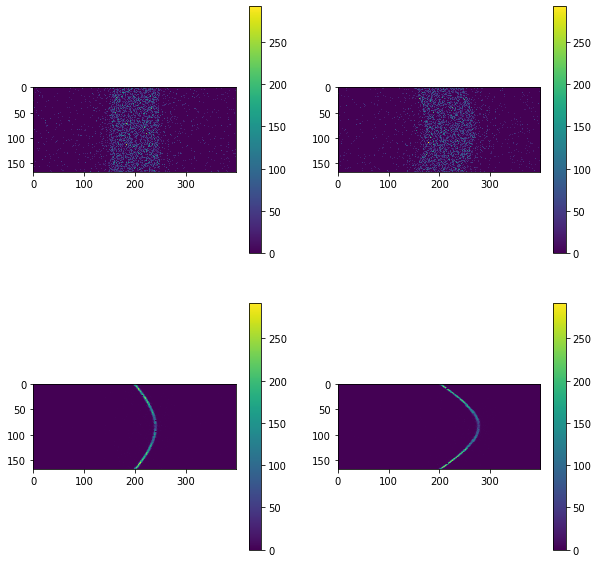

In [116]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = dict(zip(scanid, axes.flatten()))
for sid,ax in axes.items():
    ax.imshow(norm_trues[sid][50])
    fig.colorbar(img, ax=ax)

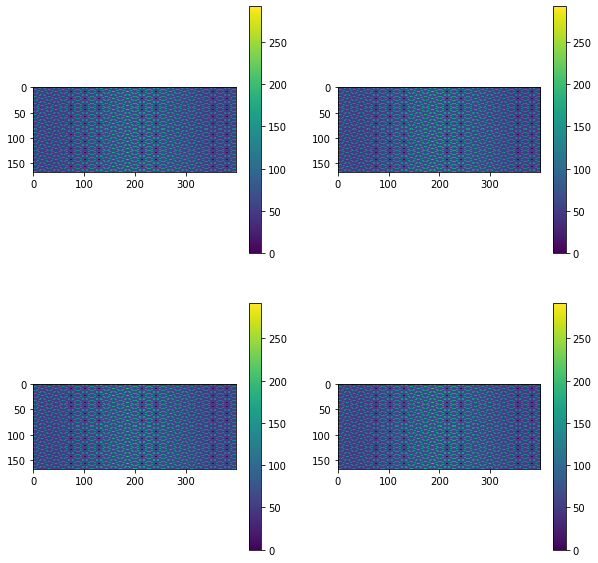

In [123]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = dict(zip(scanid, axes.flatten()))
for sid,ax in axes.items():
    ax.imshow(norms[sid][50])
    fig.colorbar(img, ax=ax)

In [139]:
lm_dset, lm_paths = kex_data.listmode()

In [210]:
fov_image = {}
small_limos = {}
keys = ['cylinder 0', 'cylinder 1', 'kanyl 0', 'kanyl 1']
for i, key in enumerate(keys):
    small_limos[key] = lm_dset[i][:100*1000]
    fov_image[key] = listmode.get_fov_image_bins(small_limos[key])

In [211]:
recon, _ = kex_data.reconstructions()
r_com = [position.center_of_mass(r) for r in recon]
r_com = dict(zip(keys, r_com))

In [212]:
importlib.reload(representation)
toflor = {key: d['tof_lor'][:, d['is_prompt']] for key, d in fov_image.items()}
masses = {key: listmode.get_norms(d['tof_lor'], d['is_prompt'], norms[key]) for key, d in fov_image.items()}

midlors = {key: representation.circle_recon(toflor[key]) for key in toflor}
shape=kex_headers.IMAGE_SHAPE
is_fov = {key: listmode.is_fov(x, shape) for key, x in midlors.items()}

In [213]:
fov_midlors = {key: x[:, is_fov[key]] for key, x in midlors.items()}
norm_midlor_img = {key: listmode.get_histogram(x, shape, weights=masses[key][is_fov[key]]) for key,x in fov_midlors.items()}
midlor_img = {key: listmode.get_histogram(x, shape) for key,x in fov_midlors.items()}

In [214]:
def plot(data, xlabel="x", ylabel="y", title_appendix=""):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    axes = dict(zip(data.keys(), axes.flatten()))
    for key, ax in axes.items():
        im = ax.imshow(data[key], origin='down')
        fig.colorbar(im, ax=ax)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(key + title_appendix)
plt.show()

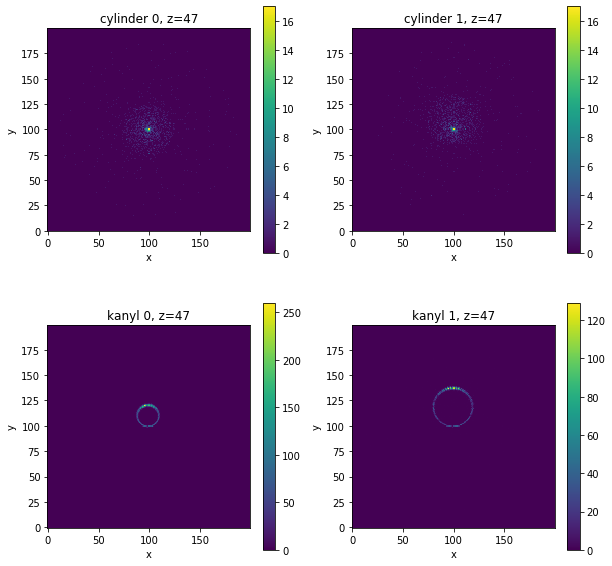

In [215]:
z = 47
views = {key: midlor_img[key][z] for key in keys}
plot(views, title_appendix=", z={}".format(z))

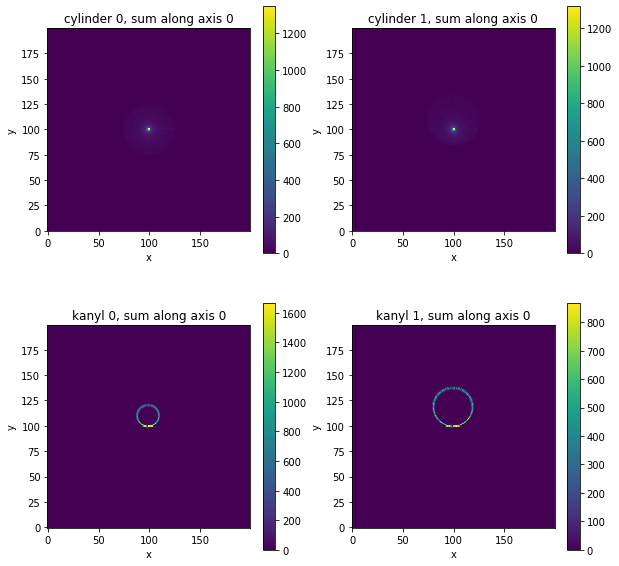

In [216]:
axis=0
views = {key: np.sum(midlor_img[key], axis=axis) for key in keys}
plot(views, title_appendix=", sum along axis {}".format(axis))

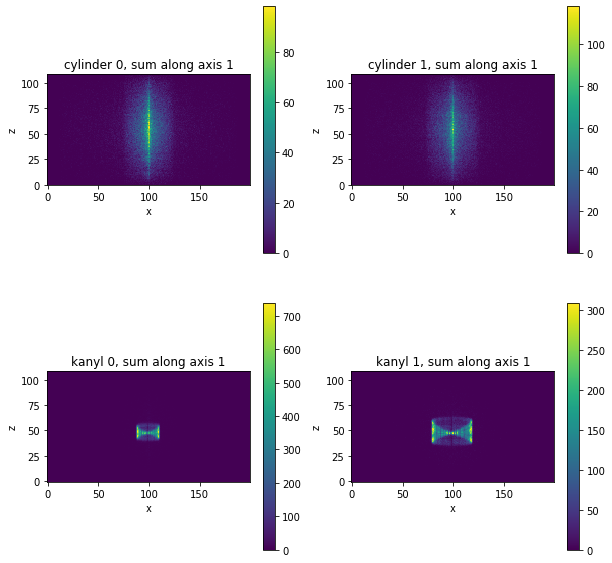

In [217]:
axis=1
views = {key: np.sum(midlor_img[key], axis=axis) for key in keys}
plot(views, title_appendix=", sum along axis {}".format(axis), ylabel='z')

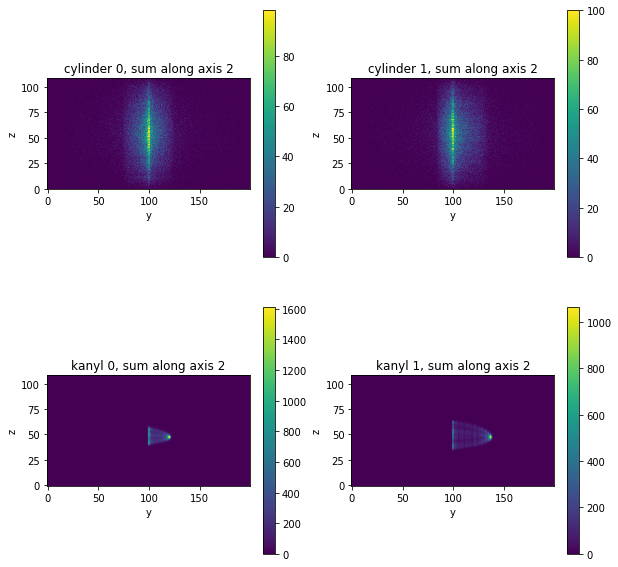

In [218]:
axis=2
views = {key: np.sum(midlor_img[key], axis=axis) for key in keys}
plot(views, title_appendix=", sum along axis {}".format(axis), xlabel='y', ylabel='z')

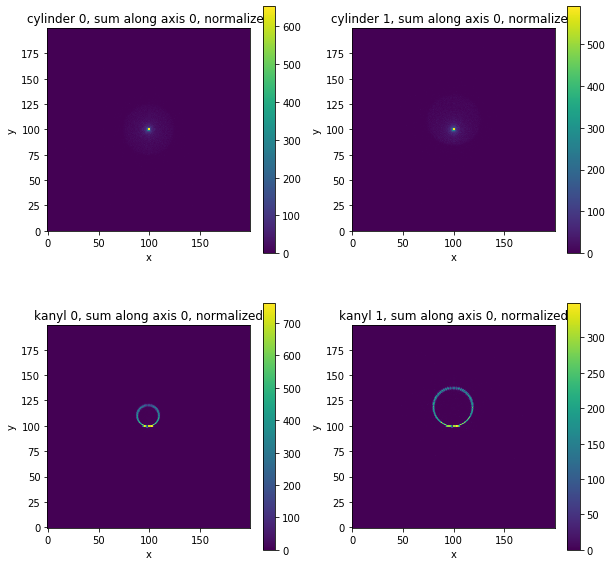

In [219]:
axis=0
views = {key: np.sum(norm_midlor_img[key], axis=axis) for key in keys}
plot(views, title_appendix=", sum along axis {}, normalized".format(axis))

In [220]:
ro_size = kex_headers.NUMBER_OF_PROJECTIONS
ro_rad = kex_headers.SCAN_DICT['ro rad']
binsize = np.cos((np.arange(ro_size)-ro_size//2)*ro_rad)
arc_norm = {key: norms[key]/np.reshape(binsize, newshape=(1,1,ro_size)) for key in keys}

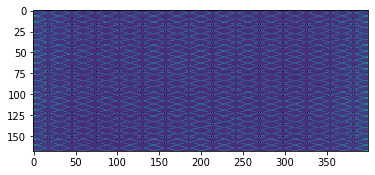

In [221]:
plt.imshow(arc_norm[keys[0]][0])

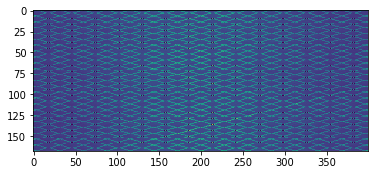

In [222]:
plt.imshow(norms[keys[0]][0])

In [223]:
arc_weights = {key: listmode.get_norms(d['tof_lor'], d['is_prompt'], arc_norm[key]) for key, d in fov_image.items()}
arc_midlor_img = {key: listmode.get_histogram(x, shape,weights=arc_weights[key]) for key,x in fov_midlors.items()}

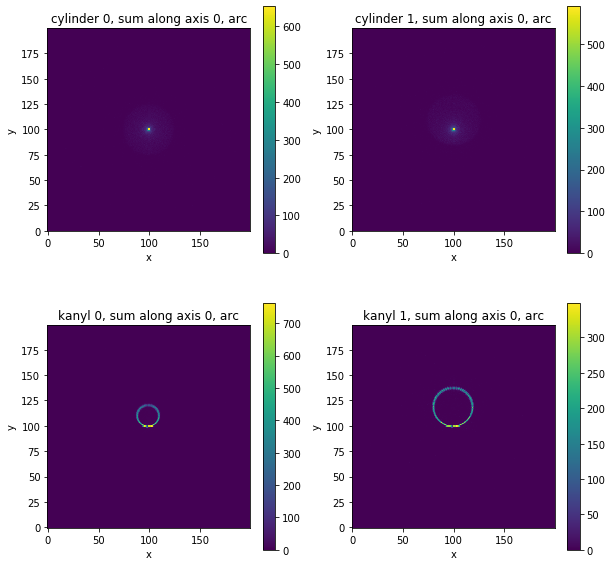

In [225]:
axis=0
views = {key: np.sum(arc_midlor_img[key], axis=axis) for key in keys}
plot(views, title_appendix=", sum along axis {}, arc".format(axis))